# Interview questions for Podproza 2024

Thank you for taking the time to meet us and discuss the Blockchain Analyst / Data science position / Python software engineer at Podproza s.r.o.

As mentioned during our meeting, I'm sending you the interview assignment that would give you a bit of a taste of the work we are doing :)

Please complete it, and provide the answers and the code you wrote for it.

Your evaluation will be based on the results achieved, the quality of your code, and its performance.

If you have any questions, don't hesitate to ask, I'd be willing to help/answer it.

You can find the documentation of Chainspect, our custom library -->[HERE](https://clovrlabs.gitlab.io/spiderbum/chainspect)<--

## Demo library

Info about this transaction [b036fd0dbbdc26b454aa56104b8e2f1cf7a223c371a03b3f38f02a0fc3e73d39](https://www.blockchain.com/explorer/transactions/btc/b036fd0dbbdc26b454aa56104b8e2f1cf7a223c371a03b3f38f02a0fc3e73d39)

In [2]:
# Import necessary libraries
import asyncio
from chainspect.redis import RedisChainspectorConnector
from chainspect.algorithms.shortest_path import address_shortest_path

# Connector for the Redis instances
connector = RedisChainspectorConnector.live()

async with connector as cs:
    # List all the outputs for the transaction b036fd0dbbdc26b454aa56104b8e2f1cf7a223c371a03b3f38f02a0fc3e73d39
    print(await cs.tx_outputs('b036fd0dbbdc26b454aa56104b8e2f1cf7a223c371a03b3f38f02a0fc3e73d39'))
    # List all the addresses of the outputs
    print(await cs.output_address_multi(['b036fd0dbbdc26b454aa56104b8e2f1cf7a223c371a03b3f38f02a0fc3e73d39_0', 
                                         'b036fd0dbbdc26b454aa56104b8e2f1cf7a223c371a03b3f38f02a0fc3e73d39_1']))
    # Display value of the output in sats (divide by 1e8 for BTC value)
    print(await cs.output_value('b036fd0dbbdc26b454aa56104b8e2f1cf7a223c371a03b3f38f02a0fc3e73d39_0'))

['b036fd0dbbdc26b454aa56104b8e2f1cf7a223c371a03b3f38f02a0fc3e73d39_0', 'b036fd0dbbdc26b454aa56104b8e2f1cf7a223c371a03b3f38f02a0fc3e73d39_1']
['1PKLTMVJ7ieFJQccbovXaaPFSuqh1ebx9r', '13bGV6VukTKYQYjeuRbBUUxdErhP3sbRkZ']
18203539511


## Exercise 1 - Bitcoin block analysis

You'll analyse the [block 750,000](https://blockchain.com/btc/block/750000) of Bitcoin Blockchain 

1. **Count the number of transactions containing:**
   - 1 to 5 outputs
   - 6 to 25 outputs
   - 26 to 100 outputs
   - 101 and more outputs (we will call them batched transactions)

2. **Compute the median and average fee of batched transactions.**

   If you don't know know how to calculate the fees, I recommend the video below

4. **Identify the most expensive transaction (highest sum of amounts of the inputs) and display:**
   - Txid (transaction id)
   - Count of inputs/outputs of this transaction
   - Sum of inputs/outputs of this transaction

In [ ]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/0_5wb5agLqE" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

####################################################################
########################### Exercise 1.1 ###########################
####################################################################

Block 750000 contains 2496 transactions:
  - 2372 of them have 1-5 TXOs
  - 97 of them have 6-25 TXOs
  - 18 of them have 26-100 TXOs
  - 9 of them have 101+ TXOs (batched)

Here's a bar plot of the four categories 



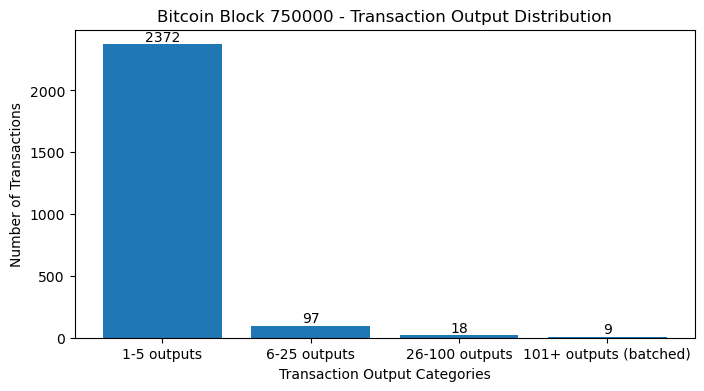


####################################################################
########################### Exercise 1.2 ###########################
####################################################################

Median fee of batched transactions: 6.415e-05 BTC (6415.0 sats)
Average fee of batched transactions: 8.126111111111111e-05 BTC (8126 sats)
Scatter plot:



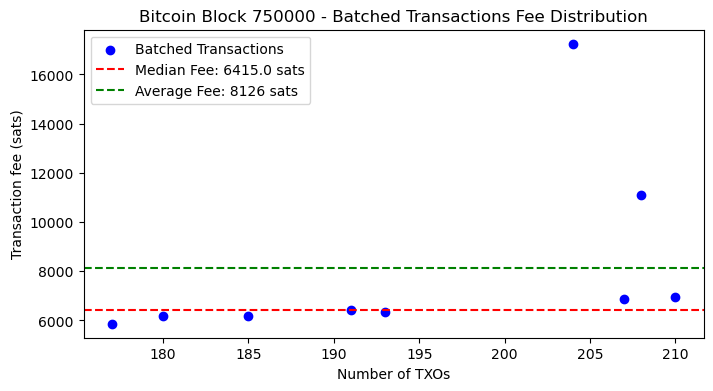


####################################################################
########################### Exercise 1.3 ###########################
####################################################################

Most expensive transaction (the one with most BTC transferred) details:
  - Txid: f1d645130125e0eaddb514d5ea5b8f9ad516941f5f77bb40c6884d2381597dc9
  - Number of incoming TXOs: 1
  - Number of outputs: 2
  - Sum of incoming TXOs' values: 6829.078302 BTC
  - Sum of outputs' values: 6829.07828177 BTC
  - Fee: 2.023e-05 BTC (2023 sats)
  - Virtual size: 166 bytes

Details of the transaction with the highest fee:
  - Txid: ffe5df09fe8f1781cc77aae9c1fd3fe67060f742317fc08d1fd7185861a9e54d
  - Number of incoming TXOs: 101
  - Number of outputs: 4
  - Sum of incoming TXOs' values: 558.69585396 BTC
  - Sum of outputs' values: 558.69223981 BTC
  - Fee: 0.00361415 BTC (361415 sats)
  - Fee: 0.00361415 BTC (361415 sats)
  - Virtual size: 16194 bytes

Details of the transaction with the highest

In [224]:
# Import necessary libraries
import asyncio
import time
from chainspect.redis import RedisChainspectorConnector
import matplotlib.pyplot as plt
import numpy as np 

# Connector for the Redis instances
connector = RedisChainspectorConnector.live()

# The address to connect to
block = 750000
start_time = time.time()

txo_ranges = {
    '1-5 TXOs': [],
    '6-25 TXOs': [],
    '26-100 TXOs': [],
    '101+ TXOs (batched)': []
}

async def query_block(cs, block):
    """
    Fetch all transactions in the specified block and get all the necessary data    
    Args:
        cs: Chainspect Redis connector.
        block: The block number to analyze.
    Returns:
        A dictionary containing transactions, inputs, outputs, sum of inputs, sum of outputs, fees and vsize.
    """
    
    tx_data = {
        'txs': [],
        'inputs': [],
        'outputs': [],
        'sum_inputs': [],
        'sum_outputs': [],
        'fee': [],
        'vsize': []
    }

    # Fetch transactions
    try:
        txs = await cs.block_height_txs(block)
    except Exception as e:
        print(f"Error fetching block {block}: {e}")
        return tx_data
    
    # Function to process each transaction, storing its inputs, outputs, sum of input TXO values, sum of output TXO values, fee and vsize
    async def process_tx(tx):
        try:
            tx_inputs = await cs.tx_inputs(tx)
            tx_outputs = await cs.tx_outputs(tx)
            tx_sum_inputs = sum([await cs.output_value(inp) for inp in tx_inputs])
            tx_sum_outputs = sum([await cs.output_value(out) for out in tx_outputs])
            tx_fee = tx_sum_inputs - tx_sum_outputs if tx_sum_inputs > tx_sum_outputs else 0
            tx_vsize = await cs.tx_vsize(tx)
            return tx_inputs, tx_outputs, tx_sum_inputs, tx_sum_outputs, tx_fee, tx_vsize
        except Exception as e:
            print(f"Error fetching data for transaction {tx}: {e}")
            return [], [], 0, 0, 0, 0

    # Concurrently process transactions
    tx_result = await asyncio.gather(*[process_tx(tx) for tx in txs])
    
    # Unpack results into tx_data
    tx_data['txs'] = txs
    for data in tx_result:
        tx_data['inputs'].append(data[0])
        tx_data['outputs'].append(data[1])
        tx_data['sum_inputs'].append(data[2])
        tx_data['sum_outputs'].append(data[3])
        tx_data['fee'].append(data[4])
        tx_data['vsize'].append(data[5])
        
    return tx_data
        
def categorise_txos(txs, outputs):
    """
    Categorise transactions based on the number of outputs.    
    Args:
        txs: List of transactions.
        outputs: List of transaction outputs.    
    Returns:
        Total number of transactions.
    """
                    
    for i, tx in enumerate(txs):
        # Assign the tx to the corresponding category, according to the number of TXOs in it
        num_outputs = len(outputs[i])
        if num_outputs <= 5:
            txo_ranges['1-5 TXOs'].append(tx)
        elif num_outputs <= 25:
            txo_ranges['6-25 TXOs'].append(tx)
        elif num_outputs <= 100:
            txo_ranges['26-100 TXOs'].append(tx)
        else:
            txo_ranges['101+ TXOs (batched)'].append(tx)

    return len(txs)
    
def analyse_batch_tx_fees(txs, outputs, fee):
    """
    Analyze the fees of batched transactions (those with more than 100 outputs).
    Args:
        txs: List of transactions.
        outputs: List of outputs per transaction.
        fee: List of each transaction's fee.
    Returns:
        The median and average fee for batched transactions.
    """
    batched_tx_fees = [fee[i] for i, tx in enumerate(txs) if len(outputs[i]) > 100]
    batched_tx_outputs = [len(outputs[i]) for i, tx in enumerate(txs) if len(outputs[i]) > 100]

    # Check if there are batched transactions in the block, calculate the median and average fees
    if batched_tx_fees:
        median_fee = np.median(batched_tx_fees)
        average_fee = np.mean(batched_tx_fees)
        return batched_tx_fees, batched_tx_outputs, median_fee, average_fee
    else:
        return None, None, None, None  # Return None if no batched transactions found
            
# async def analyze_expensive_txs(txs, inputs, outputs, sum_inputs, sum_outputs, fee, vsize):
async def analyze_expensive_txs(tx_data):
    """
    Identify the most expensive transactions by inputs, fee, and virtual size.
    Args::
        tx_data: A dictionary containing all the transactions of a block and the data corresponding to each of them that is relevant of  for our analysis 
    Returns:
        A tuple with the highest_input_tx, highest_fee_tx, highest_vsize_tx dictionaries
    """
    tx_info = {
        'txid': None,
        'num_inputs': 0,
        'sum_inputs': 0,
        'num_outputs': 0,
        'sum_outputs': 0,
        'fee': 0,
        'vsize': 0
    }

    highest_input_tx, highest_fee_tx, highest_vsize_tx = tx_info.copy(), tx_info.copy(), tx_info.copy()
            
    for i, tx in enumerate(txs):
        # Update highest input tx if this one has a higher sum of inputs
        if tx_data['sum_inputs'][i] > highest_input_tx['sum_inputs']:
            highest_input_tx = {
                'txid': tx,
                'num_inputs': len(tx_data['inputs'][i]),
                'sum_inputs': tx_data['sum_inputs'][i],
                'num_outputs': len(tx_data['outputs'][i]),
                'sum_outputs': tx_data['sum_outputs'][i],
                'fee': tx_data['fee'][i],
                'vsize': tx_data['vsize'][i]
            }
                
        # Update highest fee tx if this one has a higher fee
        if tx_data['fee'][i] > highest_fee_tx['fee']:
            highest_fee_tx = {
                'txid': tx,
                'num_inputs': len(tx_data['inputs'][i]),
                'sum_inputs': tx_data['sum_inputs'][i],
                'num_outputs': len(tx_data['outputs'][i]),
                'sum_outputs': tx_data['sum_outputs'][i],
                'fee': tx_data['fee'][i],
                'vsize': tx_data['vsize'][i]
            }
            
        # Update highest fee tx if this one has a higher vsize
        if tx_data['vsize'][i] > highest_vsize_tx['vsize']:
            highest_vsize_tx = {
                'txid': tx,
                'num_inputs': len(tx_data['inputs'][i]),
                'sum_inputs': tx_data['sum_inputs'][i],
                'num_outputs': len(tx_data['outputs'][i]),
                'sum_outputs': tx_data['sum_outputs'][i],
                'fee': tx_data['fee'][i],
                'vsize': tx_data['vsize'][i]
            }

    return highest_input_tx, highest_fee_tx, highest_vsize_tx
  
if __name__ == "__main__":
    async with connector as cs:
        # Query the block and get all relevant data
        tx_data = await query_block(cs, block)        
    
    print('####################################################################')
    print('########################### Exercise 1.1 ###########################')
    print('####################################################################')
    
    total_txs = categorise_txos(txs, outputs)
    
    # Print results 
    print(f'\nBlock {block} contains {total_txs} transactions:')
    for category, tx_list in txo_ranges.items():
        print(f'  - {len(tx_list)} of them have {category}')
    
    # Plot transaction categories
    transaction_counts = [len(txo_ranges[category]) for category in list(txo_ranges.keys())]
    print("\nHere's a bar plot of the four categories \n")
    plt.figure(figsize=(8, 4))
    bars = plt.bar(categories, transaction_counts)
    plt.xlabel('Transaction Output Categories')
    plt.ylabel('Number of Transactions')
    plt.title(f'Bitcoin Block {block} - Transaction Output Distribution')
    for bar in bars:
        xval = bar.get_x() + bar.get_width()/2
        yval = bar.get_height()
        plt.text(xval, yval, int(yval), ha='center', va='bottom')
    plt.show()
    
    print('\n####################################################################')
    print('########################### Exercise 1.2 ###########################')
    print('####################################################################')
    
    batched_tx_fees, batched_tx_outputs, median_fee, average_fee = analyse_batch_tx_fees(txs, tx_data['outputs'], tx_data['fee'])
    # Compute median and average fee of batched transactions
    if batched_tx_fees:
        print(f'\nMedian fee of batched transactions: {median_fee / 1e8} BTC ({median_fee} sats)')
        print(f'Average fee of batched transactions: {average_fee / 1e8} BTC ({round(average_fee)} sats)')
                
        # Plot the batched fees
        print(f'Scatter plot:\n')
        plt.figure(figsize=(8, 4))
        plt.scatter(batched_tx_outputs, batched_tx_fees, label='Batched Transactions', color='blue')

        # Add median and average lines
        plt.axhline(median_fee, color='red', linestyle='--', label=f'Median Fee: {median_fee} sats')
        plt.axhline(average_fee, color='green', linestyle='--', label=f'Average Fee: {round(average_fee)} sats')

        # Labeling
        plt.xlabel('Number of TXOs')
        plt.ylabel('Transaction fee (sats)')
        plt.title(f'Bitcoin Block {block} - Batched Transactions Fee Distribution')
        plt.legend()

        # Show plot
        plt.show()
    else:
        print('\nNo batched transactions found.')
        
    print('\n####################################################################')
    print('########################### Exercise 1.3 ###########################')
    print('####################################################################')
    
    async with connector as cs:
        highest_input_tx, highest_fee_tx, highest_vsize_tx = await analyze_expensive_txs(tx_data)
            
        # Print results
        print("\nMost expensive transaction (the one with most BTC transferred) details:")
        print(f"  - Txid: {highest_input_tx['txid']}")
        print(f"  - Number of incoming TXOs: {highest_input_tx['num_inputs']}")
        print(f"  - Number of outputs: {highest_input_tx['num_outputs']}")
        print(f"  - Sum of incoming TXOs' values: {highest_input_tx['sum_inputs'] / 1e8} BTC")
        print(f"  - Sum of outputs' values: {highest_input_tx['sum_outputs'] / 1e8} BTC")
        print(f"  - Fee: {highest_input_tx['fee'] / 1e8} BTC ({highest_input_tx['fee']} sats)")
        print(f"  - Virtual size: {highest_input_tx['vsize']} bytes")
        
        print("\nDetails of the transaction with the highest fee:")
        print(f"  - Txid: {highest_fee_tx['txid']}")
        print(f"  - Number of incoming TXOs: {highest_fee_tx['num_inputs']}")
        print(f"  - Number of outputs: {highest_fee_tx['num_outputs']}")
        print(f"  - Sum of incoming TXOs' values: {highest_fee_tx['sum_inputs'] / 1e8} BTC")
        print(f"  - Sum of outputs' values: {highest_fee_tx['sum_outputs'] / 1e8} BTC")
        print(f"  - Fee: {highest_fee_tx['fee'] / 1e8} BTC ({highest_fee_tx['fee']} sats)")
        print(f"  - Fee: {highest_fee_tx['fee'] / 1e8} BTC ({highest_fee_tx['fee']} sats)")
        print(f"  - Virtual size: {highest_fee_tx['vsize']} bytes")
        
        print("\nDetails of the transaction with the highest virtual size:")
        print(f"  - Txid: {highest_vsize_tx['txid']}")
        print(f"  - Number of incoming TXOs: {highest_vsize_tx['num_inputs']}")
        print(f"  - Number of outputs: {highest_vsize_tx['num_outputs']}")
        print(f"  - Sum of incoming TXOs' values: {highest_vsize_tx['sum_inputs'] / 1e8} BTC")
        print(f"  - Sum of outputs' values: {highest_vsize_tx['sum_outputs'] / 1e8} BTC")
        print(f"  - Fee: {highest_vsize_tx['fee'] / 1e8} BTC ({highest_vsize_tx['fee']} sats)")
        print(f"  - Fee: {highest_vsize_tx['fee'] / 1e8} BTC ({highest_vsize_tx['fee']} sats)")
        print(f"  - Virtual size: {highest_size_tx['vsize']} bytes")
    
    
    print(f'\nComputation time: {time.time() - start_time:.3f} seconds')


## Exercise 2 - Identifying Transaction Paths to a Target Address

### Objective
Develop a function that identifies which outputs from block `N` can reach a fixed address `X` through transaction flows within a specified maximum number of hops (steps). The function should then store and return the addresses of these initial outputs.

### Hints

1. **List all transaction outputs from a block:**
   - Retrieve and list all the transaction outputs in the specified block.

2. **Trace transaction paths:**
   - For each transaction output, trace the transaction paths forward (next transaction) to determine if it can connect to the fixed address `X`.
   - Follow the flow of transactions to see where the money goes from each output.

3. **Limit traversal:**
   - Continue tracing the transaction paths up to a maximum of `y` hops (steps from one output to another).

4. **Identify and store reachable outputs:**
   - For each output, determine if a path exists to the fixed address `X` within  `y` hops.
   - If such a path exists, store the address of the initial output.

5. **Return initial output addresses:**
   - Return a list of addresses of the initial outputs that can reach address `X` within the  `y`-hop limit.

### Success metric

The tests outlined below should be successful. Make sure you trace from the transaction output and not from the transaction address output. If you obtain different results, please provide an explanation.

In [1]:
# Import necessary libraries
import asyncio
import time
from chainspect.redis import RedisChainspectorConnector

async def trace_path(cs, output, address_to_reach, hops_remaining):
    """
    Traces the path of a transaction output to see if it reaches the target address within the allowed hops.
    
    Returns
    -------
    bool
        True if it has found a path to address address_to_reach in fewer hops than hops_remaining 
        False otherwise
    """
    
    if hops_remaining == 0:
        return False

    # Check if the output has been spent
    try:
        spent_tx = await cs.output_next_tx(output)
        if not spent_tx:
            return False    
    except Exception as e:
        print(f"Error fetching the transaction where TXO {output} was spent: {e}")
        return False

    # Get the TXOs of the transaction that spent this output
    try:
        next_tx_txos = await cs.tx_outputs(spent_tx[0])  
    except Exception as e:
        print(f"Error getting the TXOs of transaction {spent_tx[0]}, which spent TXO {output}: {e}")
        return False

    # Parallelize address fetching for each outgoing TXO in the next transaction
    try:
        next_tx_txos_addresses = await asyncio.gather(*[cs.output_address(txo) for txo in next_tx_txos])
    except Exception as e:
        print(f"Error the addresses reached by each outgoing TXO in transaction {spent_tx[0]}: {e}")
        return False
    
    # If any of the next outputs' addresses match the target address, return True
    if address_to_reach in next_tx_txos_addresses:
        return True

    # If none match, then keep branching out the tree search: recursively trace each TXO, reducing the number of hops left
    trace_results = await asyncio.gather(*[trace_path(cs, txo, address_to_reach, hops_remaining - 1) for txo in next_tx_txos])
    
    return any(trace_results)

async def get_forward_tree_address_from_block(cs, address_to_reach, block, max_distance=3) -> list[str]:
    """
    Returns a list of addresses of the initial outputs that can reach a specific address within the y-hop limit.
    
    Parameters
    ----------
    cs : Chainspector
        An instance of a `Chainspector`.
    address_to_reach : str
        Address to be used as the end of the path.
    block : int
        Block number
    max_distance : int
        Limits the distance to search. If no path within `max_distance` from
        the list of inputs in the 'block' to `address_to_reach`, the result will be an empty list.
    
    Returns
    -------
    list[str]
        A list of all addresses that have a path between 'address_to_reach' and 
        all the addresses in the selected 'block'.
    """
    list_of_addresses = []
    
    # List all transactions in block N
    try:
        txs = await cs.block_height_txs(block)
    except Exception as e:
        print(f"Error fetching the transactions in block {block}: {e}")
        return []
    
    # Fetch the TXOs of all transactions in the block concurrently
    try:
        all_txos_list = await asyncio.gather(*[cs.tx_outputs(tx) for tx in txs])
    except Exception as e:
        print(f"Error fetching the TXOs of all transactions in block {block}: {e}")
        return []
    
    # Flatten the list of of lists of TXOs
    all_txos = [txo for txos in all_txos_list for txo in txos]

    # Trace transaction paths from each output concurrently
    trace_results = await asyncio.gather(*[trace_path(cs, txo, address_to_reach, max_distance) for txo in all_txos])
    
    # Only append addresses where a valid path is found
    try:
        list_of_addresses = [await cs.output_address(all_txos[i]) for i in range(len(all_txos)) if trace_results[i]]
    except Exception as e:
        print(f"Error fetching output addresses for which a path was found: {e}")
        return []

    return list_of_addresses


async def test_get_forward_tree_address(cs):
    """
    Test function to verify that get_forward_tree_address works correctly.
    """
    # Test 1
    address_to_connect = '18mddZvpUTLqb1twgokF5HtVbb45YJFhdB'
    expected_addresses = ['1HfrzKE9K8cHQ1Le6SgARp8uoba5gruAx9', '1BvccStvq5piUqd7AByST9sqWWfpHjz3Et']
    block = 120001
    max_distance = 2
    result = await get_forward_tree_address_from_block(cs, address_to_connect, block, max_distance)
    assert set(result) == set(expected_addresses), f"Expected {expected_addresses}, but got {result}"
    print("Test 1 successful !")
    
    # Test 2
    address_to_connect = '1CDysWzQ5Z4hMLhsj4AKAEFwrgXRC8DqRN'
    expected_addresses = ['18eGJJUZeKoCHb7CXQdhJhQrKPhHUsVbfE', '1MtWU6RkJbXJkFv6Dw37Q7ukekQAXMjeQe',
                          '1PQjzVgHnz7T6Lr8zgRLop8K5qcL5xQMfz', '1Tp3NNN7c3xMaQuew87ecpZ4S3bnLaesX',
                          '1PCZT941y7t12BMWeQYTuSZL5XC5235e6a']
    block = 160004
    max_distance = 3
    result = await get_forward_tree_address_from_block(cs, address_to_connect, block, max_distance)
    assert set(result) == set(expected_addresses), f"Expected {expected_addresses}, but got {result}"
    print("Test 2 successful !")

if __name__ == "__main__":
    connector = RedisChainspectorConnector.live()
    async with connector as cs:
        start_time = time.time()
        await test_get_forward_tree_address(cs)
        print(f'\ncomputation time: {time.time() - start_time:.3f} seconds')

Test 1 successful !
Test 2 successful !

computation time: 1.043 seconds


## Exercise 3 - Floor is yours !

You have free rein to show us your analytical, scientific and creativity skills. From descriptive statistics, graphs, forecasting, benchmarking, reporting or others it is up to you!

Found 34 transactions suspicious of obfuscation attempts (large BTC input and large number of TXOs):
Block: 423259, TxID: e7afe94253d22929727410bd024e8cc92f6eb3af4e2469da47c20b9e5e5d7ea4, Input BTC: 419.0843, Number of outputs: 242, Fee: 473025 sats
Block: 423259, TxID: 84d9dc55b5b7992536255595bd82bb990ac1b995dad7c3a7347a1b1eab3b0006, Input BTC: 399.009873, Number of outputs: 229, Fee: 448302 sats
Block: 423259, TxID: 9365572ce482e635a6d9d20a0324640f06533af344376b344f3430732048196d, Input BTC: 266.03663491, Number of outputs: 216, Fee: 440117 sats
Block: 423263, TxID: 124c2023d726c12c2d7a8ccd5ab4070f01526a08daf973c0a0cf70d3dace6d10, Input BTC: 337.35112713, Number of outputs: 5014, Fee: 0 sats
Block: 423278, TxID: 6e5973f0ae5f65be69dc447fe8f82968ab1a6b60ecfb073353af0d62f950805d, Input BTC: 738.0, Number of outputs: 101, Fee: 168387 sats
Block: 423278, TxID: 696a9f9eb9e062d2c79163bcc2a2d184d2b0d40f0291eeedcb119ccca0dcf245, Input BTC: 737.63709641, Number of outputs: 101, Fee: 168387 sat

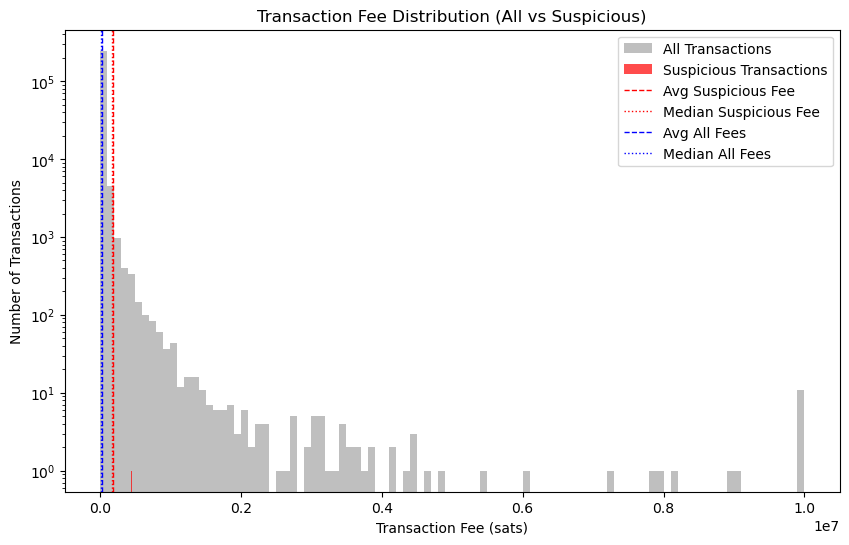


Found 8 suspicious addresses with many incoming TXOs:
Address: 3FgACmGDuVKXLG5TSt45Cm4vLJc9H5fkZj, Number of Transactions: 3191
Address: 3AbixYB8q3hHuAkFWSxUnTtqncFgRFYGDb, Number of Transactions: 2952
Address: 33StiAHYLaxDvLTixay3dW5hWvv1iK6vSv, Number of Transactions: 2581
Address: 3FvhgHr8T5DoD1oy3JLQYUXosREVE3KGzB, Number of Transactions: 1621
Address: 3NVXE53nFT5x6D6V6j4qAZGcw8RR1wrNV9, Number of Transactions: 2127
Address: 3CD1QW6fjgTwKq3Pj97nty28WZAVkziNom, Number of Transactions: 1543
Address: 13vHWR3iLsHeYwT42RnuKYNBoVPrKKZgRv, Number of Transactions: 1297
Address: 3Pfd4r6HipsdFxbBgvKKVTRkEzLYT2K1yQ, Number of Transactions: 1023

Execution time: 475.70 seconds


In [223]:
import asyncio
import time
from collections import defaultdict
import matplotlib.pyplot as plt
from chainspect.redis import RedisChainspectorConnector
import numpy as np

connector = RedisChainspectorConnector.live()

# Define the block range for the Bitfinex Hack (approximate range, 2nd of August of 2016)
block_range = range(423225, 423385)

async def query_block(cs, block):
    """
    Fetch all transactions in the specified block and get all the necessary data    
    Args:
        cs: Chainspect Redis connector.
        block: The block number to analyze.
    Returns:
        A dictionary containing transactions, inputs, outputs, sum of inputs, sum of outputs, fees and output_addresses.
    """
    
    block_txs_data = {
        'txs': [],
        'inputs': [],
        'outputs': [],
        'sum_inputs': [],
        'sum_outputs': [],
        'fees': [],
        'output_addresses': []
    }

    # Fetch transactions
    try:
        txs = await cs.block_height_txs(block)
    except Exception as e:
        print(f"Error fetching block {block}: {e}")
        return block_txs_data
    
    # Function to process each transaction, storing its inputs, outputs, sum of input TXO values, sum of output TXO values, fee and output addresses
    async def process_tx(tx):
        try:
            tx_inputs = await cs.tx_inputs(tx)
            tx_outputs = await cs.tx_outputs(tx)
            tx_sum_inputs = sum([await cs.output_value(inp) for inp in tx_inputs])
            tx_sum_outputs = sum([await cs.output_value(out) for out in tx_outputs])
            tx_fee = tx_sum_inputs - tx_sum_outputs if tx_sum_inputs >= tx_sum_outputs else -1 # beware of coinbase transactions skewing statistics
            tx_output_addresses = [await cs.output_address(txo) for txo in tx_outputs]
            return tx_inputs, tx_outputs, tx_sum_inputs, tx_sum_outputs, tx_fee, tx_output_addresses
        except Exception as e:
            print(f"Error fetching data for transaction {tx}: {e}")
            return [], [], 0, 0, 0, 0

    # Concurrently process transactions
    tx_result = await asyncio.gather(*[process_tx(tx) for tx in txs])
    
    # Unpack results into block_txs_data
    block_txs_data['txs'] = txs
    for data in tx_result:
        block_txs_data['inputs'].append(data[0])
        block_txs_data['outputs'].append(data[1])
        block_txs_data['sum_inputs'].append(data[2])
        block_txs_data['sum_outputs'].append(data[3])
        block_txs_data['fees'].append(data[4])
        block_txs_data['output_addresses'].append(data[5])
        
    return block_txs_data

async def query_blocks(cs, block_range):
    """
    Query a range of blocks and fetch transactions along with their inputs, outputs, fees, and output addresses.
    """
    blocks_data = {}  
    block_tasks = [query_block(cs, block) for block in block_range]
    all_blocks_results = await asyncio.gather(*block_tasks)

    # Organize the fetched data block by block
    for i, block in enumerate(block_range):
        blocks_data[block] = all_blocks_results[i]
        
    return blocks_data

def identify_suspicious_txs(blocks_data, threshold_input_btc=100 * 1e8, threshold_number_of_outputs=100):
    """
    Identify suspicious transactions with large input BTC amounts and many small TXOs, suspicious of obfuscation attempts.
    Args:
        blocks_data: Dictionary containing transactions data for each block.
        threshold_input: Minimum value of inputs (BTC) to be flagged as suspicious.
        threshold_output: Minimum number of outputs to be flagged as suspicious.
    Returns:
        List of suspicious transactions.
    """
    suspicious_txs = []
    for block, data in blocks_data.items():
        for i, tx in enumerate(data['txs']): 
            if data['sum_inputs'][i] > threshold_input_btc:  # Large input transactions
                if len(data['outputs'][i]) > threshold_number_of_outputs:  # Many small outputs
                    suspicious_txs.append({
                        'block': block,
                        'txid': tx,
                        'sum_inputs': data['sum_inputs'][i],
                        'num_outputs': len(data['outputs'][i]),
                        'fee': data['fees'][i],
                        'output_addresses': data['output_addresses'][i]
                    })                   
                    
    return suspicious_txs

def analyze_transaction_fees(suspicious_txs, all_fees):
    """
    Analyze the fee patterns for suspicious transactions and compare to overall transaction fees.
    Args:
        suspicious_txs: List of suspicious transactions.
        all_fees: List of fees from all transactions in the block(s).
    """
    # Extract fees for suspicious transactions
    suspicious_fees = [tx['fee'] for tx in suspicious_txs]
    
    # Descriptive statistics for suspicious transactions
    if suspicious_fees:
        avg_suspicious_fee = np.mean(suspicious_fees)
        median_suspicious_fee = np.median(suspicious_fees)
        print(f"\nSuspicious Transactions - Fee Analysis:")
        print(f"  Average Fee: {avg_suspicious_fee:.2f} sats")
        print(f"  Median Fee: {median_suspicious_fee:.2f} sats")
        print(f"  Min Fee: {min(suspicious_fees)} sats")
        print(f"  Max Fee: {max(suspicious_fees)} sats")
    else:
        print("No suspicious transactions to analyze.")
        return

    # Analyze overall transaction fees in the block(s)
    avg_all_fees = np.mean(all_fees) if all_fees else 0 
    median_all_fees = np.median(all_fees) if all_fees else 0
    low_fee_threshold = avg_all_fees * 0.5  # Threshold for low fees (50% of average fee)
    high_fee_threshold = avg_all_fees * 10  # Threshold for high fees (10 times the average fee)

    print(f"\nOverall Transactions:")
    print(f"  Average Fee: {avg_all_fees:.2f} sats")
    print(f"  Median Fee: {median_all_fees:.2f} sats")
    print(f"  Low Fee Threshold: {low_fee_threshold:.2f} sats")
    print(f"  High Fee Threshold: {high_fee_threshold:.2f} sats")

    # Identify systematic low-fee suspicious transactions
    low_fee_suspicious_txs = [tx for tx in suspicious_txs if tx['fee'] < low_fee_threshold]
    print(f"\nNumber of suspicious transactions with low fees: {len(low_fee_suspicious_txs)}")
    for tx in low_fee_suspicious_txs:
        print(f"  Txid: {tx['txid']}, Fee: {tx['fee']} sats")

    # Identify high-fee suspicious transactions
    high_fee_suspicious_txs = [tx for tx in suspicious_txs if tx['fee'] > high_fee_threshold]
    print(f"\nNumber of suspicious transactions with high fees: {len(high_fee_suspicious_txs)}")
    for tx in high_fee_suspicious_txs:
        print(f"  Txid: {tx['txid']}, Fee: {tx['fee']} sats")

    
    # Plot fee distribution of suspicious transactions vs. all transactions
    print('\n')
    plt.figure(figsize=(10, 6))

    # Adjust bin size and use log scale for better visualization
    plt.hist(all_fees, bins=100, alpha=0.5, label='All Transactions', color='gray', log=True)
    plt.hist(suspicious_fees, bins=100, alpha=0.7, label='Suspicious Transactions', color='red', log=True)

    plt.axvline(avg_suspicious_fee, color='red', linestyle='dashed', linewidth=1, label='Avg Suspicious Fee')
    plt.axvline(median_suspicious_fee, color='red', linestyle='dotted', linewidth=1, label='Median Suspicious Fee')
    plt.axvline(avg_all_fees, color='blue', linestyle='dashed', linewidth=1, label='Avg All Fees')
    plt.axvline(median_all_fees, color='blue', linestyle='dotted', linewidth=1, label='Median All Fees')

    plt.xlabel('Transaction Fee (sats)')
    plt.ylabel('Number of Transactions')
    plt.title('Transaction Fee Distribution (All vs Suspicious)')
    plt.legend()
    plt.show()

def find_high_tx_addresses(blocks_data, tx_threshold=1000):
    """
    Find addresses that have received more than `tx_threshold` transactions.
    Args:
        blocks_data: Dictionary containing transactions data for each block.
        tx_threshold: Minimum number of transactions received to be flagged as suspicious.
    Returns:
        Dictionary of suspicious addresses and their transaction counts.
    """
    address_count = defaultdict(int)

    # Count the number of incoming transactions for each address
    for block, data in blocks_data.items():
        for tx_output_addresses in data['output_addresses']:
            for output_address in tx_output_addresses:
                if output_address is not None:
                    address_count[output_address] += 1

    # Obtain addresses with a high number of incoming transactions
    suspicious_addresses = {addr: count for addr, count in address_count.items() if count > tx_threshold}
    return suspicious_addresses

if __name__ == "__main__":
    async with connector as cs:
        start_time = time.time()
        
        # Query the blocks concurrently
        blocks_data = await query_blocks(cs, block_range)
        
        # Identify suspicious transactions
        suspicious_transactions = identify_suspicious_txs(blocks_data)
        print(f"Found {len(suspicious_transactions)} transactions suspicious of obfuscation attempts (large BTC input and large number of TXOs):")
        for tx in suspicious_transactions:
            # print(tx)
            print(f"Block: {tx['block']}, TxID: {tx['txid']}, Input BTC: {tx['sum_inputs'] / 1e8}, Number of outputs: {tx['num_outputs']}, Fee: {tx['fee']} sats")

        
        # Analyze and plot the fee distribution for suspicious transactions
        # analyze_transaction_fees(suspicious_transactions)
        all_blocks_fees = [fee for block_data in blocks_data.values() for fee in block_data['fees']]
        analyze_transaction_fees(suspicious_transactions, all_blocks_fees)

        # Identify addresses with a high number of incoming transactions
        suspicious_addresses = find_high_tx_addresses(blocks_data)
        print(f"\nFound {len(suspicious_addresses)} suspicious addresses with many incoming TXOs:")
        for addr, count in suspicious_addresses.items():
            print(f"Address: {addr}, Number of Transactions: {count}")
        
        print(f"\nExecution time: {time.time() - start_time:.2f} seconds")
